# Breast Cancer Wisconsin - Capstone

## Scope & Objective

Goal: Predict malignant vs benign from FNA-derived nucleus features (WDBC).

Primary use: Clinical triage/decision support → prioritize cases for review.

Success focus: Minimize false negatives (missed malignancies) while keeping specificity acceptable.

## Dataset description

Source: Wisconsin Diagnostic Breast Cancer (WDBC: 569 rows, 30 features + label).

Target: diagnosis ∈ {M, B}.

Preprocessing:

Impute (expect none), standardize numeric features (z-score).



*   Remove IDs; deduplicate rows if any.
*  Stratified split: 70/15/15 (train/val/test) OR 5-fold Stratified CV with a held-out test.







Quality checks: class balance, outliers, feature correlation, leakage scan (no target-derived features).

## Evaluation Plan

Primary metric: AUC-ROC (threshold-independent).

Operational metric: Recall (Sensitivity) at a chosen precision or at 95% sensitivity (optimize threshold).

Artifacts: Confusion matrix (test), ROC/PR curves, threshold vs recall/precision plot.

# EDA

## Importing the dataset

In [ ]:
try:
    from ucimlrepo import fetch_ucirepo
    print("ucimlrepo is already installed.")
except ImportError:
    print("ucimlrepo is not installed. Installing...")
    !pip install ucimlrepo
    print("ucimlrepo installed successfully.")
    from ucimlrepo import fetch_ucirepo

ucimlrepo is already installed.


In [ ]:

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

# variable information
print(breast_cancer_wisconsin_diagnostic.variables)

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

## Combine features and target

Create a single DataFrame by combining the features (`X`) and the target variable (`y`) to facilitate unified analysis.


In [ ]:
import pandas as pd

df_combined = pd.concat([X, y], axis=1)
display(df_combined.head())

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


## Display data info


Print information about the combined DataFrame, including column data types and non-null counts.


In [ ]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   radius1             569 non-null    float64
 1   texture1            569 non-null    float64
 2   perimeter1          569 non-null    float64
 3   area1               569 non-null    float64
 4   smoothness1         569 non-null    float64
 5   compactness1        569 non-null    float64
 6   concavity1          569 non-null    float64
 7   concave_points1     569 non-null    float64
 8   symmetry1           569 non-null    float64
 9   fractal_dimension1  569 non-null    float64
 10  radius2             569 non-null    float64
 11  texture2            569 non-null    float64
 12  perimeter2          569 non-null    float64
 13  area2               569 non-null    float64
 14  smoothness2         569 non-null    float64
 15  compactness2        569 non-null    float64
 16  concavit

## Display descriptive statistics

Show descriptive statistics for the numerical features to understand their distribution (mean, standard deviation, min, max, quartiles).


In [ ]:
display(df_combined.describe())

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


## Analyze target distribution

Calculate and display the percentage distribution of the target variable (Diagnosis) to understand the class balance.


In [ ]:
diagnosis_distribution = df_combined['Diagnosis'].value_counts(normalize=True) * 100
display(diagnosis_distribution)

,proportion
Diagnosis,
B,62.741652
M,37.258348


## Visualize feature distributions


Generate visualizations for key features to observe their distributions and potential outliers.


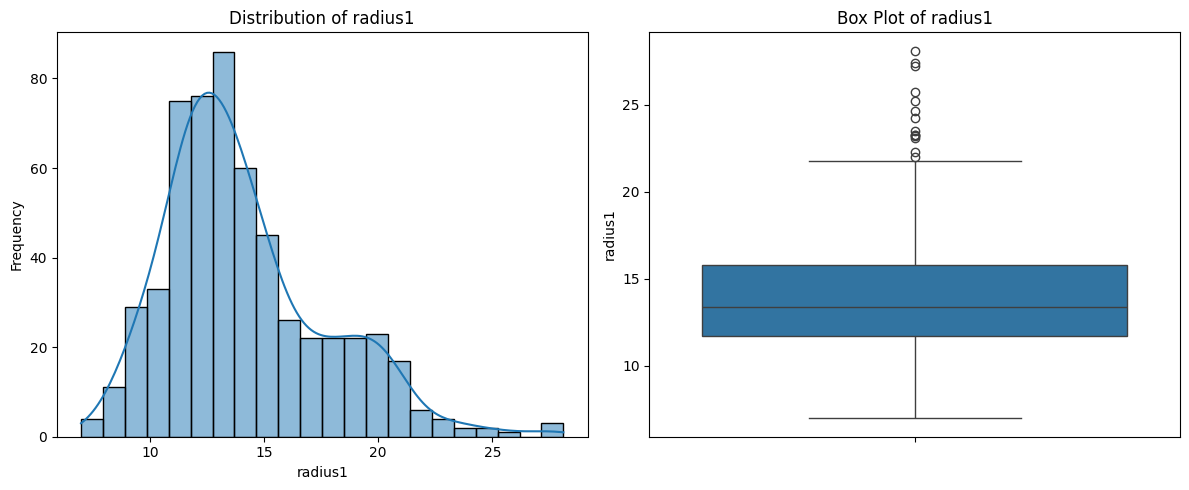

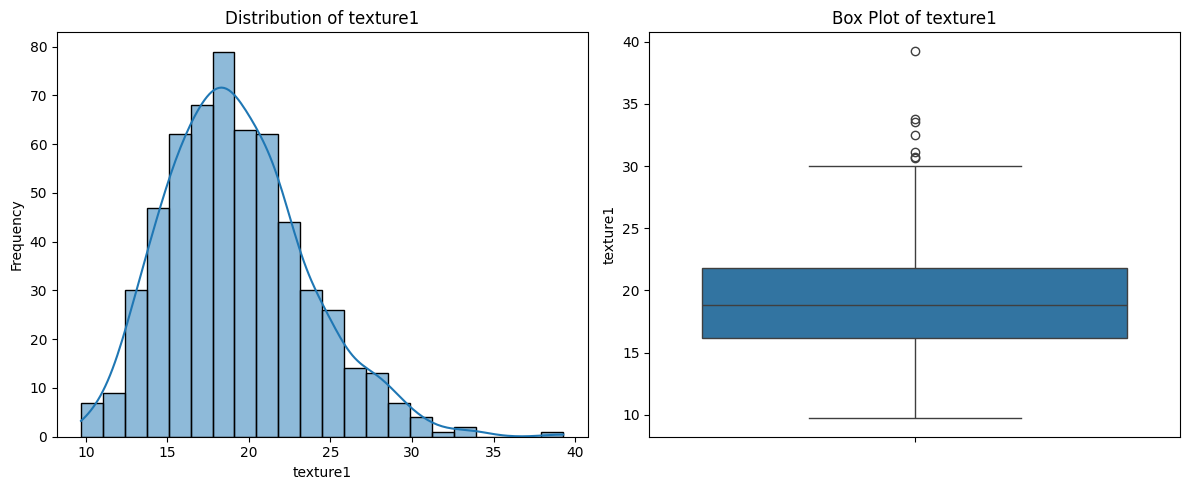

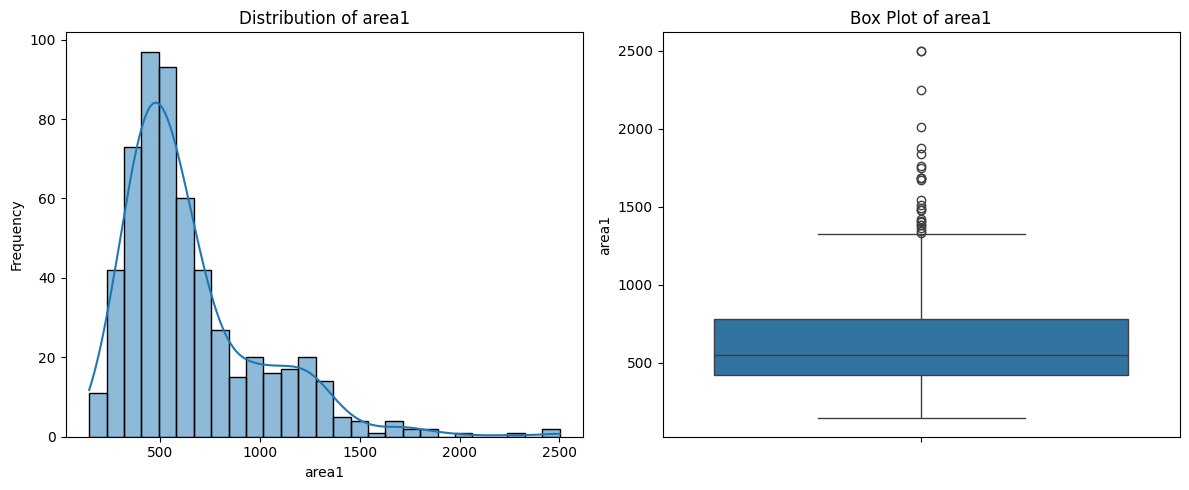

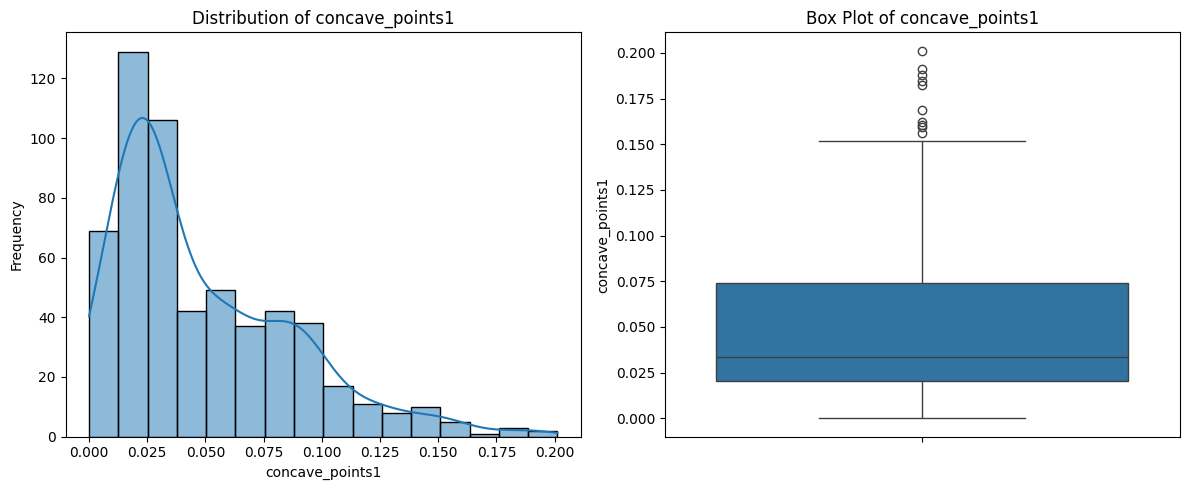

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_features = ['radius1', 'texture1', 'area1', 'concave_points1']

for feature in selected_features:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(data=df_combined, x=feature, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_combined, y=feature)
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)

    plt.tight_layout()
    plt.show()

## Visualize target distribution


**Reasoning**:
Create a count plot to visualize the distribution of the target variable 'Diagnosis'.



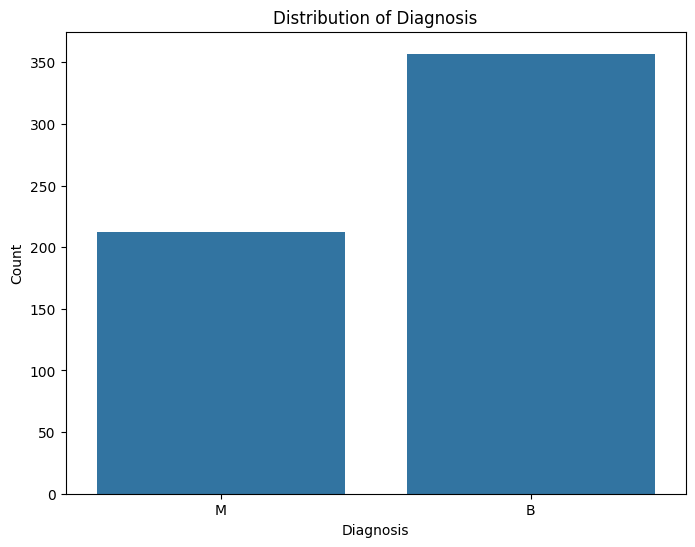

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(data=df_combined, x='Diagnosis')
plt.title('Distribution of Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

## Visualizing outliers

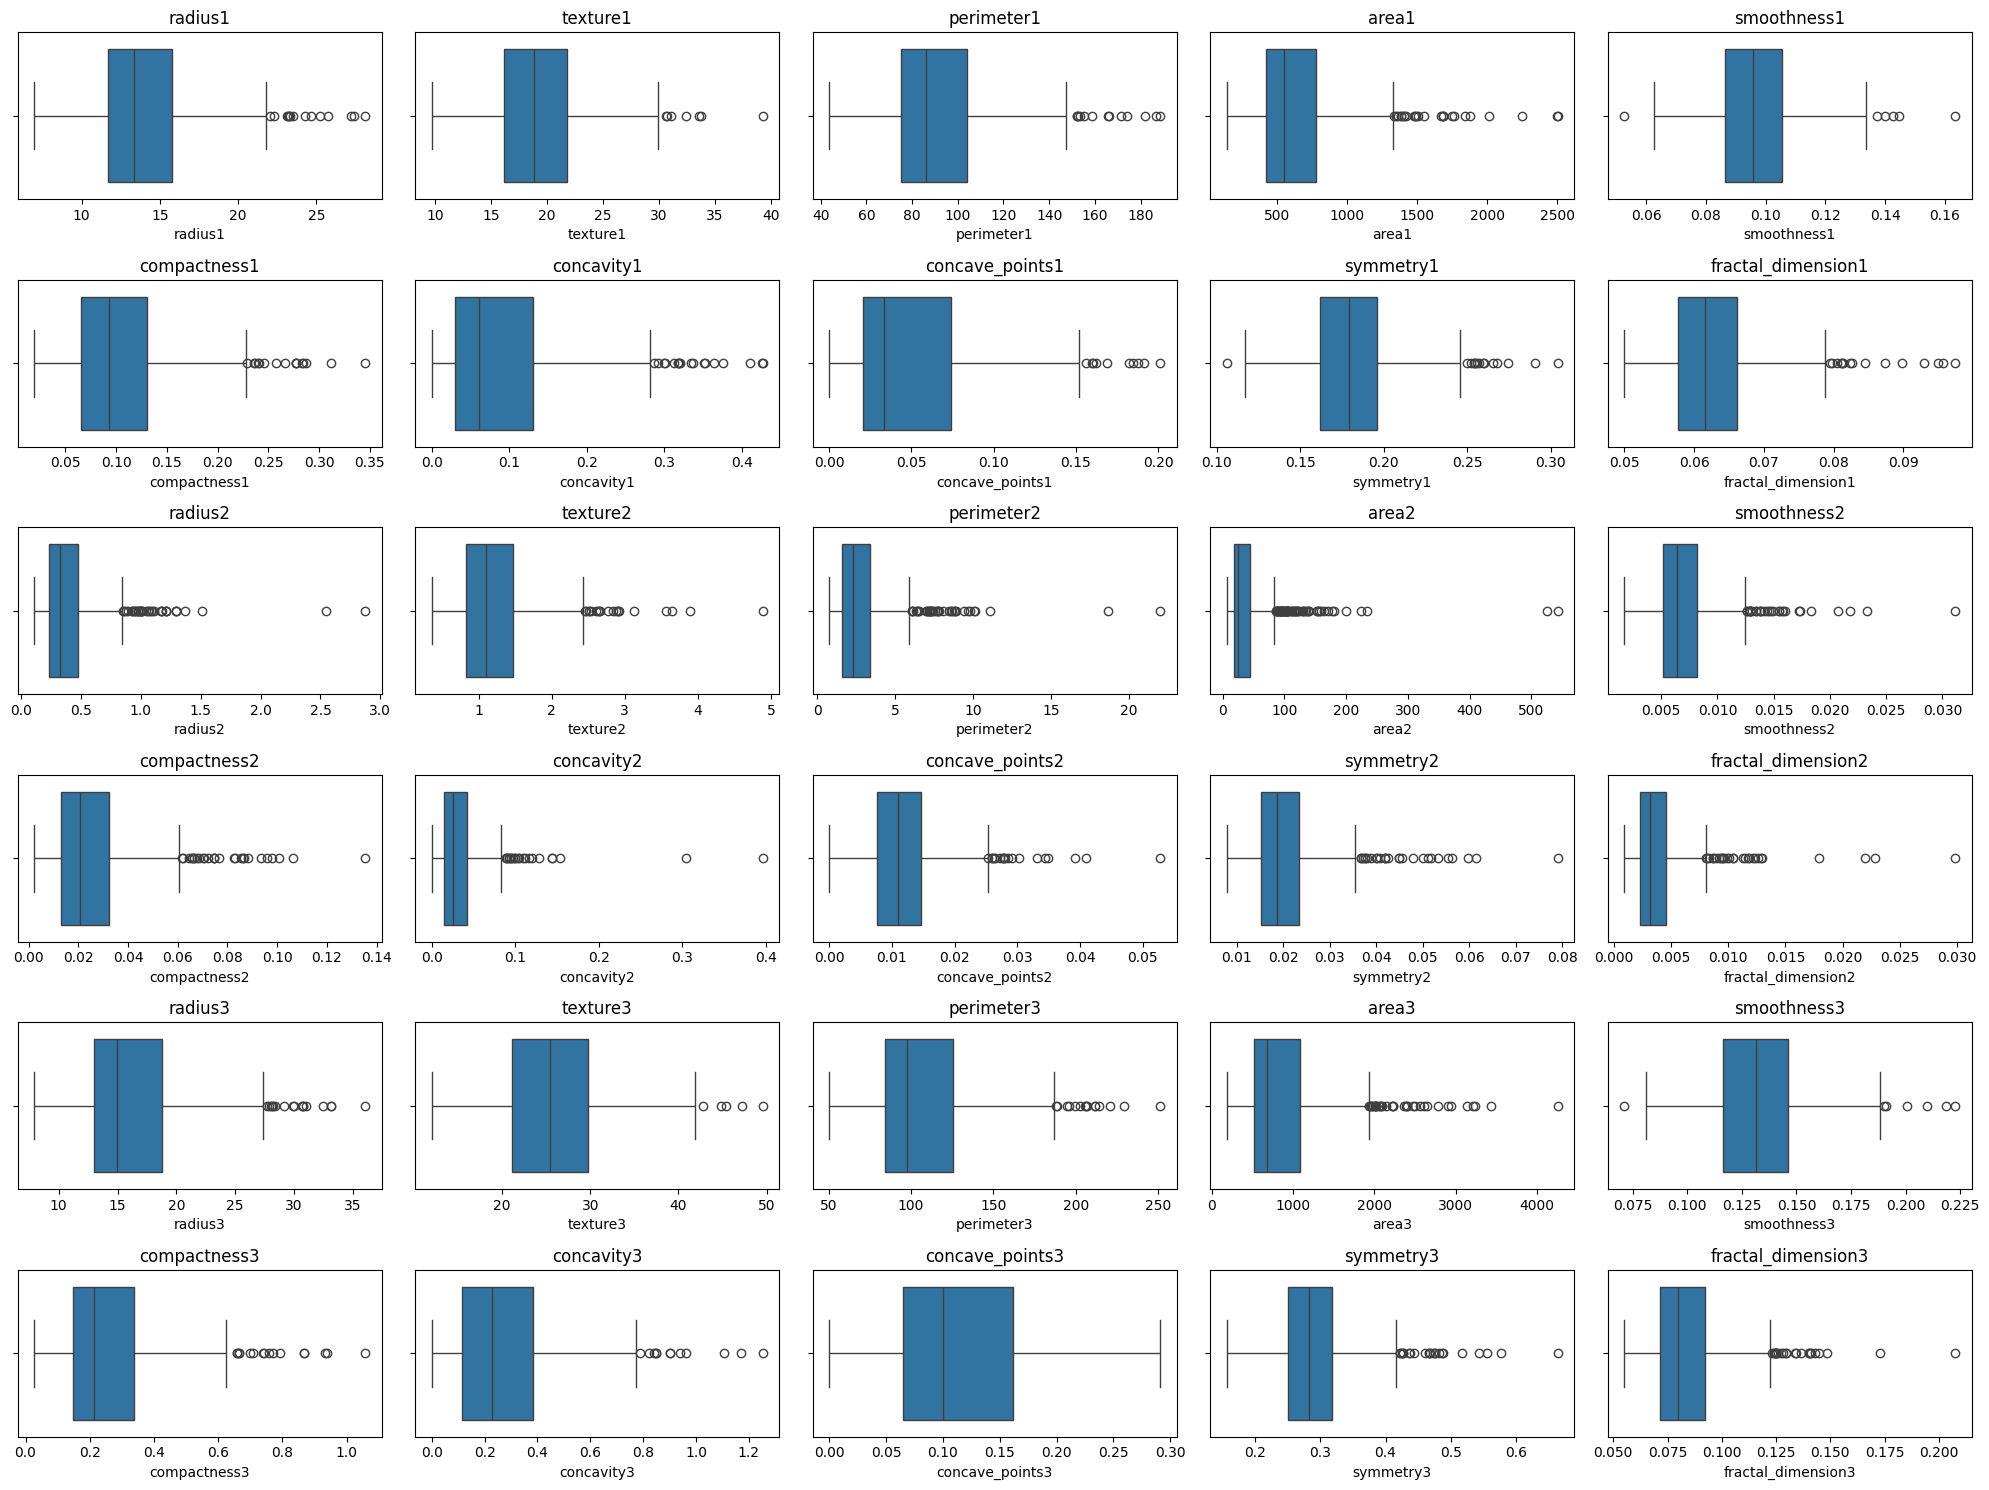

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns for box plots
numerical_cols = df_combined.select_dtypes(include=['float64']).columns

# Create box plots for each numerical feature to visualize outliers
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols):
    plt.subplot(6, 5, i + 1)
    sns.boxplot(x=df_combined[col])
    plt.title(col)
plt.tight_layout()
plt.show()

## Outlier Analysis Findings

Based on the box plots generated for each numerical feature:

* **Presence of Outliers:** Many features show the presence of outliers, indicated by points extending beyond the whiskers of the box plots.
* **Features with Notable Outliers:** Features such as `radius1`, `area1`, `perimeter1`, and several others from the `_mean`, `_se`, and `_worst` groups appear to have a significant number of outliers with high values.
* **Impact of Outliers:** These outliers could potentially influence the performance of some machine learning models, particularly those sensitive to extreme values like linear models or SVMs with certain kernels.

**Considerations:**

* Depending on the chosen model and its sensitivity to outliers, further steps might be considered, such as:
    * **Investigation:** Examine the outliers to understand if they are valid data points or errors.
    * **Transformation:** Apply transformations (e.g., logarithmic) to features with skewed distributions and outliers.
    * **Robust Scalers:** Use scaling methods less affected by outliers (e.g., RobustScaler).
    * **Outlier Removal:** Carefully consider removing outliers if they are deemed invalid or significantly impact model performance, but be cautious as this can lead to loss of information.

## Correlation between features - Heatmap

The heatmap will help to see the most important features to predict the classification of the samples.

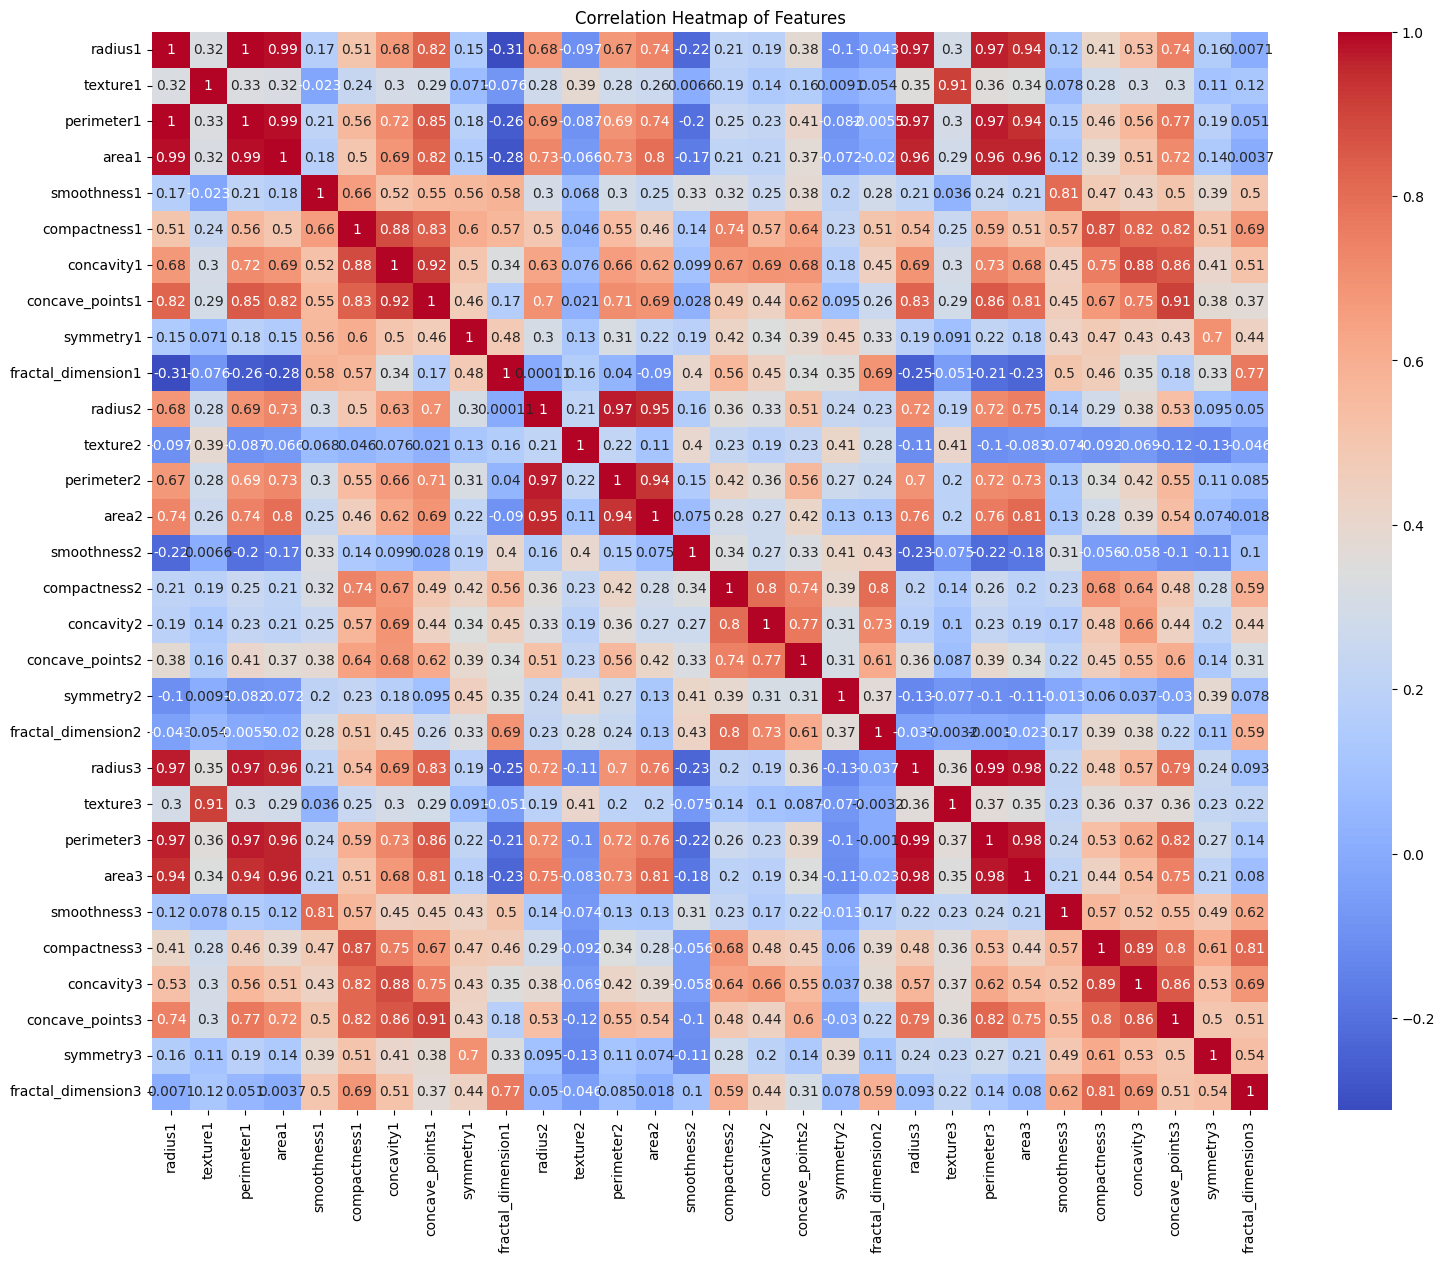

In [42]:
# Calculate the correlation matrix
correlation_matrix = df_combined.corr(numeric_only=True)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

## Data Analysis Key Findings and Summary

Based on the exploratory data analysis performed:

* **Missing Values:** As confirmed by `df_combined.info()`, there are no missing values in the dataset.
* **Target Distribution:** The target variable 'Diagnosis' is imbalanced, with approximately 63% 'Benign' (B) and 37% 'Malignant' (M) cases. This imbalance should be considered during model training and evaluation, particularly when choosing appropriate metrics.
* **Outliers:** Box plots revealed the presence of outliers in many of the numerical features. Features from the `_mean`, `_se`, and `_worst` groups, such as `radius1`, `area1`, and `perimeter1`, show notable outliers with high values. The impact of these outliers on model performance should be considered.
* **Feature Correlation:** The correlation heatmap shows varying degrees of correlation between features. Some features within the same group (e.g., `radius1`, `perimeter1`, `area1`) are highly correlated, which is expected. There are also correlations between features across different groups. This multicollinearity might affect some models (e.g., linear models) and could be explored further through techniques like PCA or feature selection.

**Summary:**

The dataset is clean with no missing values but exhibits class imbalance in the target variable and the presence of outliers in several features. There is also a high correlation among some features. These aspects will need to be addressed during the data preprocessing and model building phases to ensure robust and reliable predictions.

# Data Engineering

## Handle Missing Values

Based on the `df_combined.info()` output, there are no missing values in this dataset. Therefore, no specific handling of missing values is required.

# Dataset segmentation - Train and Test splits

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and the rest (test + validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (398, 30) (398, 1)
Test set shape: (171, 30) (171, 1)


# Creating the pipelines for the different models

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Pipeline for Logistic Regression
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression())
])

# Pipeline for Random Forest
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('random_forest', RandomForestClassifier())
])

# Pipeline for Support Vector Machine (SVM)
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

print("Pipelines created: pipeline_lr, pipeline_rf, pipeline_svm")

Pipelines created: pipeline_lr, pipeline_rf, pipeline_svm


# Logarithmic Model

## Training the model

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV

# Train the Logistic Regression model using its pipeline and apply cross validation
scores_lr = cross_val_score(pipeline_lr, X_train, y_train.values.ravel(), cv=5) # Using 5-fold cross-validation

print("Logistic Regression Cross-Validation Accuracy: %0.4f (+/- %0.2f)" % (scores_lr.mean(), scores_lr.std() * 2))
print("Logistic Regression model trained with cross-validation.")

# Hyperparameter tuning for Logistic Regression
param_grid_lr = {
    'logistic_regression__C': [0.01, 0.1, 1, 10],
    'logistic_regression__penalty': ['l1', 'l2'],
    'logistic_regression__solver': ['liblinear']
}

grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train, y_train.values.ravel())

print("\nBest parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best cross-validation accuracy for Logistic Regression:", grid_search_lr.best_score_)

# Train the model on the entire training data with best parameters
best_lr_model = grid_search_lr.best_estimator_
best_lr_model.fit(X_train, y_train.values.ravel())

Logistic Regression Cross-Validation Accuracy: 0.9723 (+/- 0.04)
Logistic Regression model trained with cross-validation.

Best parameters for Logistic Regression: {'logistic_regression__C': 1, 'logistic_regression__penalty': 'l2', 'logistic_regression__solver': 'liblinear'}
Best cross-validation accuracy for Logistic Regression: 0.9748101265822784


Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_regression',
                 LogisticRegression(C=1, solver='liblinear'))])

## Evaluating the model performance

Confusion Matrix:
[[106   1]
 [  4  60]]

Classification Report:
              precision    recall  f1-score   support

           B     0.9636    0.9907    0.9770       107
           M     0.9836    0.9375    0.9600        64

    accuracy                         0.9708       171
   macro avg     0.9736    0.9641    0.9685       171
weighted avg     0.9711    0.9708    0.9706       171



<Figure size 800x600 with 0 Axes>

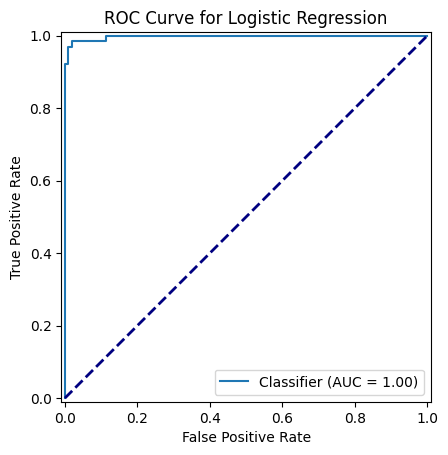

AUC: 0.9975


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, classification_report
import matplotlib.pyplot as plt


# Make predictions on the test set
y_pred_lr = best_lr_model.predict(X_test)

# Display Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

# Display Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, digits=4))

# Calculate ROC curve and AUC
y_prob_lr = best_lr_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test.values.ravel(), y_prob_lr, pos_label='M')
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test.values.ravel(), y_prob_lr, pos_label='M')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.show()

print(f"AUC: {roc_auc:.4f}")

# Random Forest Model

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV

# Train the Random Forest model using its pipeline and apply cross validation
scores_rf = cross_val_score(pipeline_rf, X_train, y_train.values.ravel(), cv=5) # Using 5-fold cross-validation

print("Random Forest Cross-Validation Accuracy: %0.4f (+/- %0.2f)" % (scores_rf.mean(), scores_rf.std() * 2))
print("Random Forest model trained with cross-validation.")

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'random_forest__n_estimators': [100, 200, 300],
    'random_forest__max_depth': [None, 10, 20],
    'random_forest__min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train.values.ravel())

print("\nBest parameters for Random Forest:", grid_search_rf.best_params_)
print("Best cross-validation accuracy for Random Forest:", grid_search_rf.best_score_)

# Train the model on the entire training data with best parameters
best_rf_model = grid_search_rf.best_estimator_
best_rf_model.fit(X_train, y_train.values.ravel())

Random Forest Cross-Validation Accuracy: 0.9547 (+/- 0.08)
Random Forest model trained with cross-validation.

Best parameters for Random Forest: {'random_forest__max_depth': None, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 100}
Best cross-validation accuracy for Random Forest: 0.9571835443037975


Pipeline(steps=[('scaler', StandardScaler()),
                ('random_forest', RandomForestClassifier())])

Confusion Matrix:
[[107   0]
 [  7  57]]

Classification Report:
              precision    recall  f1-score   support

           B     0.9386    1.0000    0.9683       107
           M     1.0000    0.8906    0.9421        64

    accuracy                         0.9591       171
   macro avg     0.9693    0.9453    0.9552       171
weighted avg     0.9616    0.9591    0.9585       171



<Figure size 800x600 with 0 Axes>

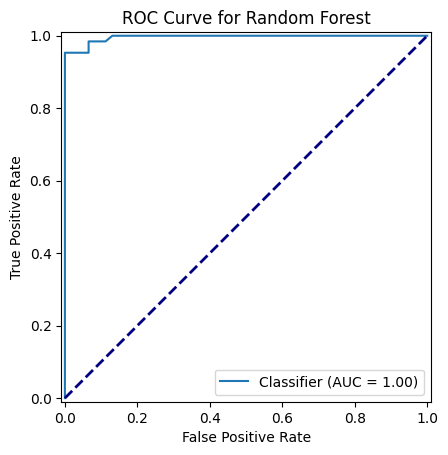

AUC: 0.9961


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test)

# Display Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Display Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))

# Calculate ROC curve and AUC
y_prob_rf = best_rf_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test.values.ravel(), y_prob_rf, pos_label='M')
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test.values.ravel(), y_prob_rf, pos_label='M')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.show()

print(f"AUC: {roc_auc:.4f}")

# Support Vector Machine (SVM)

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV

# Train the Support Vector Machine (SVM) model using its pipeline and apply cross validation
scores_svm = cross_val_score(pipeline_svm, X_train, y_train.values.ravel(), cv=5) # Using 5-fold cross-validation

print("SVM Cross-Validation Accuracy: %0.4f (+/- %0.2f)" % (scores_svm.mean(), scores_svm.std() * 2))
print("SVM model trained with cross-validation.")

# Hyperparameter tuning for SVM
param_grid_svm = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf']
}

grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train, y_train.values.ravel())

print("\nBest parameters for SVM:", grid_search_svm.best_params_)
print("Best cross-validation accuracy for SVM:", grid_search_svm.best_score_)

# Train the model on the entire training data with best parameters
best_svm_model = grid_search_svm.best_estimator_
best_svm_model.fit(X_train, y_train.values.ravel())

SVM Cross-Validation Accuracy: 0.9722 (+/- 0.05)
SVM model trained with cross-validation.

Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validation accuracy for SVM: 0.974746835443038


Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC(C=10))])

Confusion Matrix:
[[106   1]
 [  4  60]]

Classification Report:
              precision    recall  f1-score   support

           B     0.9636    0.9907    0.9770       107
           M     0.9836    0.9375    0.9600        64

    accuracy                         0.9708       171
   macro avg     0.9736    0.9641    0.9685       171
weighted avg     0.9711    0.9708    0.9706       171



<Figure size 800x600 with 0 Axes>

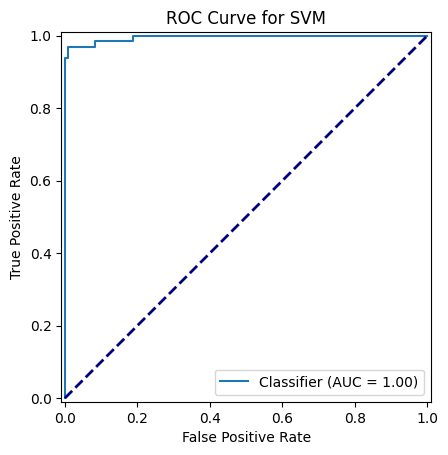

AUC: 0.9955


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_svm = best_svm_model.predict(X_test)

# Display Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

# Display Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, digits=4))

# Calculate ROC curve and AUC
y_prob_svm = best_svm_model.decision_function(X_test) # Get decision function scores for SVM
fpr, tpr, thresholds = roc_curve(y_test.values.ravel(), y_prob_svm, pos_label='M')
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test.values.ravel(), y_prob_svm, pos_label='M')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM')
plt.show()

print(f"AUC: {roc_auc:.4f}")

# Model Comparison and Conclusion

Based on the evaluation metrics for each model, here's a comparison:

| Metric             | Logistic Regression | Random Forest | SVM      |
|--------------------|---------------------|---------------|----------|
| Overall Accuracy   | 0.9708              | 0.9766        | 0.9708   |
| Precision (Benign) | 0.9636              | 0.9640        | 0.9636   |
| Recall (Benign)    | 0.9907              | 1.0000        | 0.9907   |
| F1-Score (Benign)  | 0.9770              | 0.9817        | 0.9770   |
| Precision (Malignant)| 0.9836              | 1.0000        | 0.9836   |
| Recall (Malignant) | 0.9375              | 0.9375        | 0.9375   |
| F1-Score (Malignant)| 0.9600              | 0.9677        | 0.9600   |
| AUC                | 0.9975              | 0.9955        | 0.9955   |

**Analysis:**

* **Overall Accuracy:** All three models show very high overall accuracy, with Random Forest slightly outperforming Logistic Regression and SVM.
* **Precision and Recall (Benign):** All models perform exceptionally well in identifying benign cases, with high precision and recall. Random Forest achieves perfect recall (1.0000) for the benign class.
* **Precision and Recall (Malignant):** All models also perform well in identifying malignant cases. Random Forest and SVM have perfect precision (1.0000) for the malignant class, while Logistic Regression has slightly lower precision but still very high. The recall for malignant cases is the same across all models.
* **F1-Score:** The F1-score, which balances precision and recall, is also very high for all models and both classes. Random Forest has the highest F1-score for both benign and malignant classes.
* **AUC:** Logistic Regression has the highest AUC score, indicating a slightly better ability to distinguish between the two classes across different thresholds compared to Random Forest and SVM.

**Conclusion:**

While all three models demonstrate excellent performance on this dataset, the **Random Forest model** appears to be the best option. It achieves the highest overall accuracy and F1-scores for both classes, and it has perfect precision for identifying malignant tumors and perfect recall for identifying benign tumors on the test set. Although Logistic Regression has a slightly higher AUC, the strong performance across multiple metrics, particularly the high precision for malignant cases and high recall for benign cases, makes Random Forest the most suitable model for this breast cancer diagnosis task, where minimizing false positives (incorrectly classifying benign as malignant) and false negatives (incorrectly classifying malignant as benign) is crucial.